<a href="https://colab.research.google.com/github/dzrich/PhD_Research_in_CausalML/blob/main/SimulationCausalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn  dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [6]:
!pip uninstall -y networkx dowhy
!pip install networkx==2.8.8 dowhy==0.6

Found existing installation: networkx 3.5
Uninstalling networkx-3.5:
  Successfully uninstalled networkx-3.5
Found existing installation: dowhy 0.12
Uninstalling dowhy-0.12:
  Successfully uninstalled dowhy-0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 9.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [1]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
import matplotlib.pyplot as plt

# --- Simulated Source Data ---
np.random.seed(0)
source_data = pd.DataFrame({
    "age": np.random.normal(35, 10, 1000),
    "income": np.random.normal(50000, 10000, 1000),
    "treatment": np.random.binomial(1, 0.5, 1000),
})
# Define outcome with causal dependence
source_data["outcome"] = (0.3 * source_data["treatment"] +
                          0.01 * source_data["income"] -
                          0.02 * source_data["age"] +
                          np.random.normal(0, 1, 1000))

# --- Simulated Target Data (different population) ---
target_data = pd.DataFrame({
    "age": np.random.normal(45, 12, 1000),  # shift in demographics
    "income": np.random.normal(60000, 12000, 1000),
    "treatment": np.random.binomial(1, 0.5, 1000),
})
target_data["outcome"] = (0.3 * target_data["treatment"] +
                          0.01 * target_data["income"] -
                          0.02 * target_data["age"] +
                          np.random.normal(0, 1, 1000))

In [4]:
target_data.head()

,age,income,treatment,outcome
0,53.836937,63294.043444,1,632.761909
1,40.367960,62240.169126,1,622.043992
2,44.869028,68925.155537,0,691.074260
3,36.230319,51297.735575,1,510.938965
4,29.277632,47285.693110,0,473.794384


In [2]:
# --- Causal Inference on Source Data ---
model_source = CausalModel(
    data=source_data,
    treatment="treatment",
    outcome="outcome",
    common_causes=["age", "income"]
)
identified_estimand_source = model_source.identify_effect()
estimate_source = model_source.estimate_effect(
    identified_estimand_source,
    method_name="backdoor.linear_regression"
)

/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [3]:
# --- Causal Inference on Target Data ---
model_target = CausalModel(
    data=target_data,
    treatment="treatment",
    outcome="outcome",
    common_causes=["age", "income"]
)
identified_estimand_target = model_target.identify_effect()
estimate_target = model_target.estimate_effect(
    identified_estimand_target,
    method_name="backdoor.linear_regression"
)

/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [4]:
# --- Compare ATEs for Generalizability ---
ate_source = estimate_source.value
ate_target = estimate_target.value
delta = abs(ate_source - ate_target)

print("ATE on Source Data:", ate_source)
print("ATE on Target Data:", ate_target)
print("Generalizability Gap (|Source - Target|):", delta)

ATE on Source Data: 0.3101508584517205
ATE on Target Data: 0.26232450643681204
Generalizability Gap (|Source - Target|): 0.04782635201490848


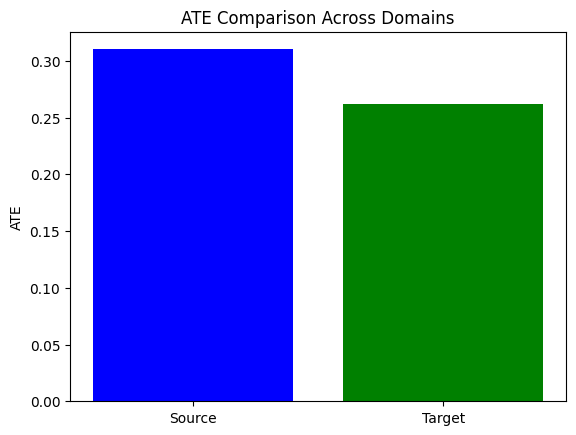

In [5]:
# Optional visualization
plt.bar(["Source", "Target"], [ate_source, ate_target], color=["blue", "green"])
plt.title("ATE Comparison Across Domains")
plt.ylabel("ATE")
plt.show()

In [6]:
refute = model_source.refute_estimate(
     identified_estimand_source,
    estimate_source,
    method_name="random_common_cause"
)
print(refute)

Refute: Add a Random Common Cause
Estimated effect:0.3101508584517205
New effect:0.31015277367947647



/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Nearest Neighbor Counterfactual Accuracy (Approximate)

In [8]:
!pip install  econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Simulated dataset with binary treatment
np.random.seed(0)
n = 1000
df = pd.DataFrame({
    'age': np.random.normal(35, 10, n),
    'income': np.random.normal(50000, 10000, n),
    'treatment': np.random.binomial(1, 0.5, n)
})
df['outcome'] = (0.5 * df['treatment'] +
                 0.02 * df['income'] -
                 0.01 * df['age'] +
                 np.random.normal(0, 1, n))

# Define variables
X = df[['age', 'income']]
T = df['treatment']
Y = df['outcome']

# Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3)

# Causal Forest for estimating ITE
model_y = RandomForestRegressor()
model_t = LogisticRegression()

estimator = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True)
estimator.fit(Y_train, T_train, X=X_train)

# Estimate ITEs (Individual Treatment Effects)
ite = estimator.effect(X_test)

# Predict counterfactual outcome:
# If treatment was 1 → predict what would happen if T=0, and vice versa
T_cf = 1 - T_test  # flip treatment
Y_cf_pred = estimator.const_marginal_effect(X_test).reshape(-1) * (T_cf - T_test)

# Approximate counterfactual outcome
Y_pred_cf = Y_test + Y_cf_pred

# Approximate counterfactual accuracy:
# Find nearest neighbors that actually received the counterfactual treatment
from sklearn.neighbors import NearestNeighbors

cf_data = X_test.copy()
cf_data['treatment'] = T_cf.values
actual_cf = df[df['treatment'] != T_test.values[0]]  # different from actual treatment

# Use nearest neighbor to approximate true counterfactual
nn = NearestNeighbors(n_neighbors=1)
nn.fit(actual_cf[['age', 'income']])
_, indices = nn.kneighbors(cf_data[['age', 'income']])
Y_true_cf_approx = actual_cf.iloc[indices.flatten()]['outcome'].values

# Compare predicted vs. approx counterfactuals
cf_accuracy = np.mean(np.abs(Y_pred_cf - Y_true_cf_approx) < 1.0)  # within tolerance
print(f"Approximate Counterfactual Accuracy: {cf_accuracy:.2f}")

Approximate Counterfactual Accuracy: 0.54


In [3]:
df.head()


,age,income,treatment,outcome
0,52.640523,55559.626797,0,1110.710126
1,39.001572,58924.738873,0,1177.787300
2,44.787380,45776.851759,0,914.187089
3,57.408932,51047.140294,1,1021.189716
4,53.675580,52280.533251,0,1043.681893


# Binary Example

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from econml.dml import CausalForestDML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# Simulate binary treatment and binary outcome data
np.random.seed(0)
n = 1000
df = pd.DataFrame({
    'age': np.random.normal(35, 10, n),
    'income': np.random.normal(50000, 10000, n),
    'treatment': np.random.binomial(1, 0.5, n)
})

# Binary outcome depends on treatment, age, income
logits = (0.5 * df['treatment'] + 0.00003 * df['income'] - 0.03 * df['age'])
probs = 1 / (1 + np.exp(-logits))
df['outcome'] = np.random.binomial(1, probs)

# Define variables
X = df[['age', 'income']]
T = df['treatment']
Y = df['outcome']

# Train-test split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3)

# Fit causal model
model_y = RandomForestClassifier()
model_t = LogisticRegression()

estimator = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    discrete_outcome=True,
    random_state=42
)
estimator.fit(Y_train, T_train, X=X_train)

# Estimate treatment effects
ite = estimator.effect(X_test)

# Flip treatment to create counterfactual scenario
T_cf = 1 - T_test  # if treated → control, if control → treated
Y_cf_pred = estimator.const_marginal_effect(X_test).reshape(-1) * (T_cf - T_test)

# Compute counterfactual outcome probability
Y_pred_cf_prob = np.clip(Y_test + Y_cf_pred, 0, 1)
Y_pred_cf_binary = (Y_pred_cf_prob >= 0.5).astype(int)

# Nearest neighbor matching: find actual counterfactual units
cf_data = X_test.copy()
cf_data['treatment'] = T_cf.values

actual_cf = df[df['treatment'] != T_test.values[0]]  # people who got flipped treatment

nn = NearestNeighbors(n_neighbors=1)
nn.fit(actual_cf[['age', 'income']])
_, indices = nn.kneighbors(cf_data[['age', 'income']])
Y_true_cf_approx = actual_cf.iloc[indices.flatten()]['outcome'].values

# Counterfactual accuracy
cf_accuracy = accuracy_score(Y_true_cf_approx, Y_pred_cf_binary)
print(f"Approximate Counterfactual Accuracy (Binary Outcome): {cf_accuracy:.2f}")

Approximate Counterfactual Accuracy (Binary Outcome): 0.80


In [5]:
df.head()


,age,income,treatment,outcome
0,52.640523,55559.626797,0,1
1,39.001572,58924.738873,0,1
2,44.787380,45776.851759,0,0
3,57.408932,51047.140294,1,1
4,53.675580,52280.533251,0,1


# Binary Outcome and Continous Treatment

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from econml.dml import CausalForestDML

# Simulate data
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    'age': np.random.normal(35, 10, n),
    'income': np.random.normal(60000, 15000, n),
    'interest_rate': np.random.uniform(0.01, 0.20, n)  # Continuous treatment
})

# Outcome: binary decision based on continuous treatment
logits = -5 * df['interest_rate'] + 0.00002 * df['income'] - 0.02 * df['age']
probs = 1 / (1 + np.exp(-logits))
df['loan_approved'] = np.random.binomial(1, probs)

# Variables
X = df[['age', 'income']]
T = df['interest_rate']
Y = df['loan_approved']

# Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3)

# Fit Causal Forest with binary outcome
model_y = RandomForestClassifier()
model_t = LinearRegression()

est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=False,
    discrete_outcome=True,
    random_state=42
)
est.fit(Y_train, T_train, X=X_train)

# Predict ITEs for an intervention: what if interest_rate = 0.05
hypothetical_treatment = 0.05
cf_effect = est.const_marginal_effect(X_test).reshape(-1)
T_cf = np.full_like(T_test, hypothetical_treatment)

# Predict counterfactual outcomes
Y_cf_pred_prob = np.clip(Y_test + cf_effect * (T_cf - T_test), 0, 1)
Y_cf_pred_binary = (Y_cf_pred_prob >= 0.5).astype(int)

# Nearest neighbor approximate counterfactual
df_cf_pool = df[np.abs(df['interest_rate'] - hypothetical_treatment) < 0.01]
nn = NearestNeighbors(n_neighbors=1)
nn.fit(df_cf_pool[['age', 'income']])
_, indices = nn.kneighbors(X_test)
Y_cf_true_approx = df_cf_pool.iloc[indices.flatten()]['loan_approved'].values

# Accuracy
cf_accuracy = accuracy_score(Y_cf_true_approx, Y_cf_pred_binary)
print(f"Counterfactual Accuracy (continuous treatment, binary outcome): {cf_accuracy:.2f}")


Counterfactual Accuracy (continuous treatment, binary outcome): 0.54


In [8]:
df.head(20)

,age,income,interest_rate,loan_approved
0,39.967142,80990.331549,0.087350,1
1,33.617357,73869.505244,0.022542,1
2,41.476885,60894.455549,0.076276,0
3,50.230299,50295.948334,0.031090,0
4,32.658466,70473.349704,0.163565,1
5,32.658630,65902.280781,0.190061,0
6,50.792128,73427.898300,0.023740,1
7,42.674347,69527.577025,0.191472,1
8,30.305256,75743.290730,0.109290,1
9,40.425600,51971.471827,0.066917,0


In [9]:
print(df['interest_rate'].dtype)

float64


In [11]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# --- Simulated Source Data ---
np.random.seed(0)
source_data = pd.DataFrame({
    "age": np.random.normal(35, 10, 1000),
    "income": np.random.normal(50000, 10000, 1000),
    "treatment": np.random.uniform(0, 1, 1000)  # continuous treatment
})

# Create binary outcome from continuous treatment
logits_source = (0.8 * source_data["treatment"] +
                 0.00003 * source_data["income"] -
                 0.02 * source_data["age"])
prob_source = 1 / (1 + np.exp(-logits_source))
source_data["outcome"] = np.random.binomial(1, prob_source)

# --- Simulated Target Data (shifted population) ---
target_data = pd.DataFrame({
    "age": np.random.normal(45, 12, 1000),
    "income": np.random.normal(60000, 12000, 1000),
    "treatment": np.random.uniform(0, 1, 1000)  # same treatment range
})

logits_target = (0.8 * target_data["treatment"] +
                 0.00003 * target_data["income"] -
                 0.02 * target_data["age"])
prob_target = 1 / (1 + np.exp(-logits_target))
target_data["outcome"] = np.random.binomial(1, prob_target)

# --- Causal Inference on Source Data ---
model_source = CausalModel(
    data=source_data,
    treatment="treatment",
    outcome="outcome",
    common_causes=["age", "income"]
)
identified_estimand_source = model_source.identify_effect()
estimate_source = model_source.estimate_effect(
    identified_estimand_source,
    method_name="backdoor.linear_regression",
    method_params={"model": LogisticRegression()}
)

# --- Causal Inference on Target Data ---
model_target = CausalModel(
    data=target_data,
    treatment="treatment",
    outcome="outcome",
    common_causes=["age", "income"],
     graph=dags)


identified_estimand_target = model_target.identify_effect()
estimate_target = model_target.estimate_effect(
    identified_estimand_target,
    method_name="backdoor.linear_regression",
    method_params={"model": LogisticRegression()}
)

# --- Compare ATEs for Generalizability ---
ate_source = estimate_source.value
ate_target = estimate_target.value
delta = abs(ate_source - ate_target)

print("ATE on Source Data:", ate_source)
print("ATE on Target Data:", ate_target)
print("Generalizability Gap (|Source - Target|):", delta)



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


ATE on Source Data: 0.10081451365923311
ATE on Target Data: 0.163482724604329
Generalizability Gap (|Source - Target|): 0.06266821094509589


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


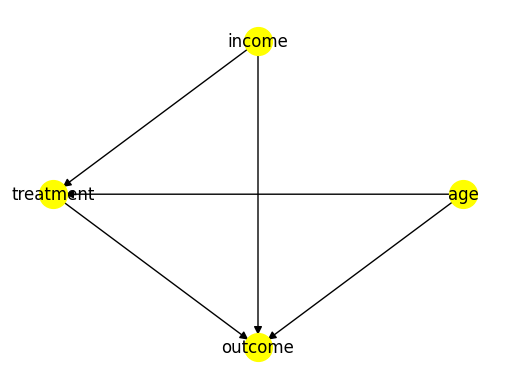

In [18]:
model_source.view_model()

In [14]:
source_data.head(10)


,age,income,treatment,outcome
0,52.640523,55559.626797,0.400510,1
1,39.001572,58924.738873,0.410916,1
2,44.787380,45776.851759,0.103253,1
3,57.408932,51047.140294,0.519099,1
4,53.675580,52280.533251,0.096803,1
5,25.227221,52014.799467,0.889762,1
6,44.500884,55407.735853,0.061845,1
7,33.486428,31819.223696,0.449694,1
8,33.967811,49506.759299,0.284694,1
9,39.105985,52390.336012,0.154869,0


In [16]:
!apt-get update
!apt-get install graphviz graphviz-dev -y
!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,798 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,045 kB]
Get:13 http://archive.ubuntu.com/ubuntu 